In [1]:
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
import sys
sys.path.append('../../')

from src.preparation.data import Data
from src.modeling.KNNCFModel import KNNRecommender
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt

# Import User + Movie baseline model

from src.modeling.DampedBaselineModel import DampedBaselineModel

In [2]:
ratings_df = Data.get_rating(filtered=False)

In [3]:
def cart_prod(df_1, df_2):
    df_1['_dummy_'], df_2['_dummy_'] = 1, 1
    return pd.merge(df_1, df_2, on='_dummy_').drop('_dummy_', axis=1)

In [4]:
n_splits = 5

k_list = [1, 2, 5, 10, 20, 50, 100, 200]
mode_list = ['user', 'item']
i_fold_list = np.arange(n_splits)
df_1 = pd.DataFrame({'k': k_list})
df_2 = pd.DataFrame({'mode': mode_list})
df_3 = pd.DataFrame({'i_fold': i_fold_list})
results_df = reduce(cart_prod, [df_1, df_2, df_3])
results_df.head(10)

k  mode  i_fold
0  1  user       0
1  1  user       1
2  1  user       2
3  1  user       3
4  1  user       4
5  1  item       0
6  1  item       1
7  1  item       2
8  1  item       3
9  1  item       4

In [5]:
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
for (k, mode), group in results_df.groupby(['k', 'mode']):
    print("k={}, mode={}: i_fold= ".format(k, mode), end='')
    for (index, row), (train_inds, test_inds) in zip(group.iterrows(), kf.split(ratings_df)):
        print("{}, ".format(row['i_fold']))
        train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
        baseline_algo = DampedBaselineModel(damping_factor=10)
        t1 = datetime.now()
        rec = KNNRecommender(mode=row['mode'], k=row['k'], baseline_algo=baseline_algo)
        rec.fit(train_df)
        preds = rec.predict(test_df[['user_id', 'movie_id']])
        rmse = sqrt(mean_squared_error(preds, test_df['rating']))
        results_df.loc[index, 'RMSE'] = rmse
        dt = (datetime.now() - t1).total_seconds()
        print("{:5.3f}   dt={:.2f} seconds".format(rmse, dt))
        results_df.loc[index, 'time'] = dt

k=1, mode=item: i_fold= 0, 
1.059   dt=1.09 seconds
1, 
1.055   dt=1.02 seconds
2, 
1.048   dt=0.87 seconds
3, 
1.059   dt=0.86 seconds
4, 
1.050   dt=0.92 seconds
k=1, mode=user: i_fold= 0, 
1.060   dt=0.85 seconds
1, 
1.059   dt=0.83 seconds
2, 
1.057   dt=0.82 seconds
3, 
1.064   dt=0.77 seconds
4, 
1.063   dt=0.85 seconds
k=2, mode=item: i_fold= 0, 
0.979   dt=0.93 seconds
1, 
0.978   dt=0.94 seconds
2, 
0.971   dt=0.89 seconds
3, 
0.977   dt=1.13 seconds
4, 
0.979   dt=1.02 seconds
k=2, mode=user: i_fold= 0, 
0.999   dt=0.89 seconds
1, 
0.997   dt=0.88 seconds
2, 
0.992   dt=0.82 seconds
3, 
0.998   dt=0.84 seconds
4, 
1.013   dt=0.86 seconds
k=5, mode=item: i_fold= 0, 
0.934   dt=0.93 seconds
1, 
0.931   dt=0.96 seconds
2, 
0.932   dt=0.99 seconds
3, 
0.932   dt=0.95 seconds
4, 
0.942   dt=0.96 seconds
k=5, mode=user: i_fold= 0, 
0.959   dt=0.80 seconds
1, 
0.959   dt=0.84 seconds
2, 
0.953   dt=0.82 seconds
3, 
0.959   dt=0.83 seconds
4, 
0.971   dt=0.80 seconds
k=10, mode=item:

In [9]:
baseline_df = pd.DataFrame({'i_fold': i_fold_list})

for (index, row), (train_inds, test_inds) in zip(baseline_df.iterrows(), kf.split(ratings_df)):
    print("i_fold={}: RMSE=".format(row['i_fold']), end='')
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    baseline_algo = DampedBaselineModel(damping_factor=10)
    baseline_algo.fit(train_df)
    preds = baseline_algo.predict(test_df[['user_id', 'movie_id']])
    rmse = sqrt(mean_squared_error(preds, test_df['rating']))
    baseline_df.loc[index, 'RMSE'] = rmse
    print("{:5.3f}".format(rmse))

i_fold=0: RMSE=0.959
i_fold=1: RMSE=0.954
i_fold=2: RMSE=0.951
i_fold=3: RMSE=0.954
i_fold=4: RMSE=0.968


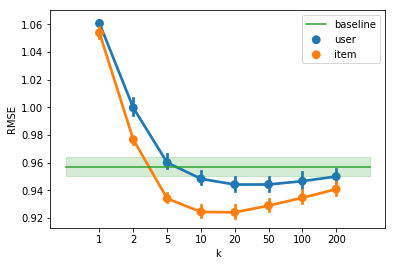

In [10]:
base_avg = baseline_df['RMSE'].mean()
base_std = baseline_df['RMSE'].std()
sns.pointplot(data=results_df, x='k', hue='mode', y='RMSE')
nk = results_df['k'].nunique()
plt.plot([-1, nk], [base_avg, base_avg], label='baseline', color='C2')
plt.fill_between([-1, nk], [base_avg - base_std]*2, [base_avg+base_std]*2, color='C2', alpha=0.2)
plt.legend()
plt.show()